<a
href="https://colab.research.google.com/github/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/04_DL_for_Wildlife_Images/04_DL_for_Wildlife_Images_Solutions.ipynb"
target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In
Colab"/></a>

# Week 4: Deep Learning for Wildlife Images [Solutions]

Last week we have seen how to design, train, and evaluate a deep learning model in PyTorch. Today,
we will use that knowledge to make sense of wildlife images!

This notebook will require a little bit less coding from your side, but it contains lots of
information that is hopefully going to be useful for your own projects! Also, make sure you have
gone through last week's exercise; we will re-use lots of concepts and code from it on training deep
learning models again today.


## Contents

1. [Data: Camera Trap Images](#1-data-camera-trap-images)
2. [Introduction to Convolutional Neural Networks](#2-introduction-to-convolutional-neural-networks)
3. [CNNs for Camera Trap Imagery](#3-cnns-for-camera-trap-imagery)
4. [Object Detection](#4-object-detection)
5. [Summary](#5-summary)


## Notes

- If a line starts with the fountain pen symbol (🖌️), it asks you to implement a code part or
answer a question.
- Lines starting with the light bulb symbol (💡) provide important information or tips and tricks.

---

## 1. Data: Camera Trap Images

Before we even talk about models, let us start with the data and problem we want to tackle: camera
trap images.

As you surely know, camera traps are little devices mounted in the wild (_e.g._, on a tree) that
contain a camera, as well as a motion sensor:

<img src="https://raw.githubusercontent.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/refs/heads/main/04_DL_for_Wildlife_Images/ct.png" width="400" />

They automatically start taking sequences of images once the motion sensor gets triggered, such as
by an animal passing in front of the camera trap.

In this exercise, we will use parts of a curated dataset of camera trap images over North America,
the [Caltech Camera Traps](https://lila.science/datasets/caltech-camera-traps) dataset.

Let us import it from Google Drive:

1. Open this link:
   [https://drive.google.com/file/d/1LyLtfF4ke5yQCkJDMhXaULs_AME4Wn2H/view?usp=sharing](https://drive.google.com/file/d/1LyLtfF4ke5yQCkJDMhXaULs_AME4Wn2H/view?usp=sharing)
2. Right-click the zip file, select "Organise" > "Add shortcut". Then, select "My Drive" and click
   "Add".
3. Run the following two code cells.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [ ]:
!unzip -qqn /content/drive/MyDrive/cct20_data_subset.zip -d /content

DATA_FOLDER = '/content/cct20_data_subset'

Open the file browser in Google Colab (folder icon to the left) and take a look at the dataset
(navigate to `/content/cct20_data_subset`).

You will notice a few things:
* It already comes divided into train/val/test splits (see Session 2 about that).
* File `classes.txt` contains a list of species, line-by-line and in order.
* The same species names are in subfolders called "images" under the train/val/test folders. This
  basically tells us what type of animal each of the images shows therein – we can use it as a
  ground truth to train and test our model!
* Don't bother with the "labels" subfolders for now, we will use those later.

Let us visualise some random images from the `train/images` folder below:

In [ ]:
import os
import pathlib
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# find all images in training folder
images = glob.glob(os.path.join(DATA_FOLDER, 'train', 'images', '**/*.jpg'), recursive=True)


# show a few random images
img_paths = np.random.choice(images, size=25, replace=False)

plt.figure(figsize=(15, 15))
for idx, img_path in enumerate(img_paths):
    img = Image.open(img_path)
    plt.subplot(5,5,idx+1)
    plt.imshow(img)
    plt.title(pathlib.Path(img_path).parent.name)
    plt.axis('off')
plt.tight_layout()

If you think about labelling those images, or predicting them with a machine learning model, you
should already now see some potential challenges:
* Animals may be tiny, partially hidden behind bushes, blurred by movement.
* Some images are in greyscale: these have been taken with infrared vision at night.
* There is an "empty" class: as it turns out, motion sensors of camera traps can easily get
  triggered by movement other than caused by animals, such as leaves rustling on a tree.


We can also plot the histogram of the number of images per species in the training set:

In [ ]:
# histogram of number of training images per class (species)
train_folder = os.path.join(DATA_FOLDER, 'train', 'images')
classes = [folder for folder in os.listdir(train_folder) \
           if os.path.isdir(os.path.join(train_folder, folder))]
num_imgs = [len(os.listdir(os.path.join(DATA_FOLDER, 'train', 'images', species))) for species in classes]

plt.bar(np.arange(len(classes)), num_imgs)
_ = plt.xticks(np.arange(len(classes)), classes, rotation=90)
plt.ylabel('Image count')

print(f'Total number of images: {len(images)}')

Some species have extremely few images – this **class imbalance** might cause a problem for a model.


Nonetheless, we have everything we need to predict those species with a model:
* Data/input features $\mathbf{X}$: our images
* Target/ground truth labels $\mathbf{y}$: the species label
* Train/val/test splits

All we need to proceed is a model that can handle those images.

---

## 2. Introduction to Convolutional Neural Networks

Let us first briefly recap what we saw in the morning, and talk about Convolutional Neural Networks
(CNNs).


### 2.1 Convolution

As you have seen, the key innovation of CNNs is the convolution operation: here, a filter matrix (or
kernel) of weights is applied over locations on a regular grid. This is in contrast to the
fully-connected layer, where each input tensor value is processed by a dedicated weight.

<img src="https://tikz.net/janosh/conv2d.png" width="500" />

([image source](https://tikz.net/janosh/conv2d.png))


In the above example, our input tensor has $7\times7=49$ values. Thus, we would have needed 49
weight parameters for a linear/fully-connected layer, whereas the convolution layer only needed
$3\times3=9$ values. Of course, this difference becomes more significant the larger the inputs are
(think about digital images).


Like all other layers, such as Linear, ReLU, _etc._ we have seen last week, convolution layers
are available via the [torch.nn](https://pytorch.org/docs/stable/nn.html) subpackage:

In [1]:
from torch import nn

We can apply a convolution operation in any dimension – we don't have to do it in an image plane,
but could also do it across just one or three dimensions, for example.

However, since we will be dealing with images below, we will make use of the
[nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) layer.

Like nn.Linear, nn.Conv2d layers takes some basic input/output hyperparameters:
* `in_channels`: number of input channels ("depth" of the input)
* `out_channels`: number of output channels (number of convolution filters we will apply)

Unlike nn.Linear, we can specify convolution operations with many other properties, such as kernel
size, stride, padding, _etc._ See the documentation linked above for more information.

Let us create a new 2D-convolution layer and try it out on a tensor below.

In [ ]:
import torch

# initialise new 2D convolution layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=8,
                       kernel_size=5,
                       stride=1,
                       padding=0)


# create a random input tensor
input_tensor = torch.randn(size=(1, 3, 32, 32))         # BxCxHxW

# apply convolution layer to input
result = conv_layer(input_tensor)

print(f'Output tensor size after convolution: {result.size()}.')

Above, our `input_tensor` is of size `BxCxHxW`. If we assume this is an image, these dimensions
would signify:
* `B`: batch size (here: 1 = one image)
* `C`: number of channels (here: 3 for red, green, blue)
* `H`: image height
* `W`: image width


💡 PyTorch usually follows this ordering for image recognition models.


As you can see, the output size behaves as follows:
* The first dimension (batch size) still says 1 – we feed one input, we get one output.
* The second dimension changed from 3 to 8. Our input tensor had three channels. However, we
  specified our `conv_layer` as having eight output channels. What happens in the background here is
  that we get eight filter kernels, each of size `3x5x5`: since our input has three channels, each
  filter must have a weight for each location _and_ channel. When convolving the input with the
  filter, it still multiplies each filter weight with its appropriate input (spatial location _and_
  channel), sums all results together, and returns the sum at the centre of the current location (as
  in the figure above).
* Sizes of the third and fourth dimension (height and width of the feature plane, such as the input
  image) depend on the convolution hyperparameters (you have seen the formula in the lecture).


🖌️ Change some of the `nn.Conv2d` hyperparameters (_e.g._, set `stride=2`) and observe the
changes in output size they result in. Can you find values that do not work with our input tensor?
Can you guess why?

_Answer:_

The input of a convolution layer must at least be as large as the convolution kernel. As soon as the
kernel is larger than the input, we get an error, because there are not enough input positions to
calculate correlations with. To resolve this issue, `kernel_size` must be reduced or else `padding`
increased (although adding too much padding, _e.g._ more than half the kernel size, is not sensible
anymore at some point).

Moreover, `in_channels` must be exactly the same as the input's number of channels.

All of this applies to any layer in the model, and one therefore must be careful in designing it so
that it can operate with _e.g._ the right type and size of images and intermediate tensors.

### 2.2 Pooling

You have seen this one too in the lecture: pooling. Here, we aggregate the values locally, for
example by taking the maximum or average, without learning specific parameters.

Let's see this for ourselves on an example:

In [ ]:
# define tensor of specific values
input_tensor = torch.tensor([[1, 5, 3, 5],
                             [8, 2, 3, 3],
                             [9, 0, 2, 1],
                             [-1, 4, 2, 5]]).float()

# make sure the tensor is of correct size
input_tensor = input_tensor.view((1, 1, 4, 4))      # again: BxCxHxW

# create pooling layer
max_pool = nn.AvgPool2d(kernel_size=2)

# apply
result = max_pool(input_tensor)

print(result)

You should be able to reproduce what we have seen in the lecture.

🖌️ Try changing the kernel size, stride, adding padding, or switching the layer to `nn.AvgPool2d` and
observe the output. You should be able to reproduce what happens.

Ultimately, we can chain many convolution, pooling and other layers (_e.g._, ReLU) together to
obtain a CNN:

<img src="https://raw.githubusercontent.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/refs/heads/main/04_DL_for_Wildlife_Images/cnn.png" width="800" />


In the above illustration, you notice that the intermediate feature tensors output by each layer get
smaller and smaller in spatial dimension, until they collapse to a linear, one-dimensional vector
(output of "Pooling 2"). At this point, the model has summarised the whole image contents into this
non-spatial vector, so we can add final linear/fully-connected layer that _e.g._ returns logits of
the label classes the model is supposed to predict. Many CNNs for image classification do that.

We will use one such architecture below – you have seen it at the end of the lecture already!

### 2.3 ResNet

There isn't a definitive recipe in designing models; oftentimes people just tried ideas. As a
result, various different CNN architectures have been proposed over the years. These are the most
noteworthy ones:
* [LeNet](https://ieeexplore.ieee.org/abstract/document/726791): the "original" from 1998 by LeCun,
  designed to classify handwritten digits in postal codes (the MNIST dataset).
* [AlexNet](https://proceedings.neurips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html):
  the architecture that started the Deep Learning hype in 2012.
* [Inception](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html):
  this employed the idea of intermediate classifiers (in the middle of the model) for better
  training.
* [ResNet](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html):
  this added skip connections and enabled training very deep models, beating humans in accuracy on
  ImageNet for the first time.


There are others, including particularly lightweight architectures like
[MobileNet](https://arxiv.org/abs/1704.04861) and [SqueezeNet](https://arxiv.org/abs/1602.07360)
(for _e.g._ on-device computing, such as on a smartphone, drone, or camera trap), but the one we
will be looking at below is ResNet.

ResNet is so popular that comes built-in with PyTorch. We can call it from the
[Torchvision](https://pytorch.org/vision/stable/index.html) sub-package, which, as the name
suggests, implements all sorts of useful utilities for applying deep learning on computer vision.

ResNet comes in different sizes. Let us create an instance of the smallest one below, ResNet-18:

In [ ]:
from torchvision import models

# create ResNet-18 model instance
model = models.resnet18()

# print the model's architecture
print(model)

You will see all the layers in order in the print output above. Compared to our model from last
week, this is way bigger already! Also, you should be familiar with most of the layers listed:
* `Conv2d` and `MaxPool2d`: we've just seen those above. Note the hyperparameters like
  `kernel_size`.
* `ReLU`: nonlinear activation function used by default in ResNet (and many other CNNs). You have
  seen this last week.
* `BatchNorm2d`: we have talked about this during the lecture. It helps training by learning to
  normalise intermediate layer output tensors.
* `AdaptiveAvgPool2d`: you may be able to imagine what this does.
  [Here](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html) is the
  documentation of it.
* `Sequential`: this is just a `torch.nn` helper that applies a list of pre-defined layers in order;
  nothing special.
* `Linear` (last layer): this maps the penultimate, one-dimensional feature vector to 1000 output
  class logits.


Why 1000 outputs, you may ask? In the lecture, we talked about the
[ImageNet](https://www.image-net.org/challenges/LSVRC/index.php) classification challenge, which
jump-started CNNs. This has images of 1000 everyday categories that appear in images and that a
model has to predict, hence the 1000 outputs. Those categories are listed in a default order, and we
can download them:

In [ ]:
import urllib.request

with urllib.request.urlopen('https://raw.githubusercontent.com/xmartlabs/caffeflow/refs/heads/master/examples/imagenet/imagenet-classes.txt') as url:
    imagenet_classes = url.read().decode('utf-8').split('\n')

imagenet_classes = [item for item in imagenet_classes if len(item) > 0]

print(f'Number of ImageNet classes: {len(imagenet_classes)}')
print(f'First five classes: {imagenet_classes[:5]}')

---

## 3. CNNs for Camera Trap Imagery

### 3.1 From Images to Tensors

Okay, let us use the above ResNet-18 model instance to predict an image from our camera trap
dataset.

Let's load a random image into memory. There are multiple libraries in Python to do so; here, we use
the [Python Imaging Library (PIL)](https://pypi.org/project/pillow/).

In [ ]:
from PIL import Image

# select an image we want to load
img_path = os.path.join(DATA_FOLDER, 'train/images/car/58c34ce5-23d2-11e8-a6a3-ec086b02610b.jpg')

# load image
img = Image.open(img_path).convert('RGB')

# image properties
print(f'Image width: {img.width}')
print(f'Image height: {img.height}')

# visualise
_ = plt.imshow(img)

We now have an object `img` in memory. However, a PyTorch model requires a `torch.Tensor` as input,
so we need to convert it to that. And it doesn't just stop there: it also needs to be of the right
size, and have the right (normalised) pixel values.

Torchvision implements various [Transforms](https://pytorch.org/vision/0.9/transforms.html) to help
us with that. We can compose multiple of those together to perform all of these steps properly:

In [ ]:
import torchvision.transforms as T

# compose transforms together
transforms = T.Compose([
    T.Resize(size=[224, 224]),                  # ResNet requires images of size 224x224 pixels
    T.ToTensor(),                               # convert from PIL to torch.Tensor
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])      # z-score images by R, G, B band
])

# use it to transform PIL image
img_tensor = transforms(img)

print(f'Tensor size: {img_tensor.size()}')
print(f'Tensor data type: {img_tensor.type()}')
print(f'Tensor value min/max: {img_tensor.min()}/{img_tensor.max()}')

You will see below why we use such seemingly odd values to normalise our tensor.

Let's make a prediction!

In [ ]:
# very important: put model in evaluation mode so that BatchNorm & Co. work properly
model.eval()

with torch.no_grad():
    pred = model(img_tensor.unsqueeze(0))       # unsqueeze: remember the first dimension needs to be our batch size

print(f'Prediction size: {pred.size()}')

We get our 1000 logits for all the ImageNet classes we have seen above. If we normalise them with
the softmax, we get class probabilities; taking the $\arg\max$ then gives us the class index:

In [ ]:
pred_softmax = pred.softmax(dim=1)      # dim=1: along second (class) dimension

confidence, y_hat = pred_softmax.max(1)

# our predicted class now is the ImageNet category at position y_hat
pred_class = imagenet_classes[y_hat]

print(f'Prediction: {pred_class} ({confidence.item():.2%})')

Hmm, that's odd. The class is most certainly wrong, and the confidence might be really low, too.


### 3.2 Pre-trained Models

Remember how model parameters (weights and biases) are initialised randomly whenever we create a new
layer? The same happened above when we defined our ResNet-18. Thus, this model is totally
unoptimised and does not know how to make good predictions. Let's change that!

Torchvision actually has model states available for us that are pre-trained on ImageNet, for free!
All we have to do is initialise our model with an extra argument:

In [58]:
# re-create our ResNet-18. Notice the "weights" argument
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Now, re-run the above two code cells and watch what happens.

### 3.3 Transfer Learning

Cool, we now get a more sensible prediction! However, this is just for images with cars, and the
confidence isn't really good either. That model will likely fail if the image is too difficult, and
will not know what to do for species it doesn't know about. Let's predict some random images from
our dataset:

In [ ]:
# take a few random images
img_paths = np.random.choice(images, size=16, replace=False)

plt.figure(figsize=(15,15))

for iidx, img_path in enumerate(img_paths):
    # load image
    img = Image.open(img_path).convert('RGB')

    # transform
    img_tensor = transforms(img)

    # predict
    with torch.no_grad():
        pred = model(img_tensor.unsqueeze(0))
        pred_sm = pred.softmax(dim=1)
        conf, y_hat = pred_sm.max(1)
        pred_label = imagenet_classes[y_hat]
        if len(pred_label) > 12:
            # shorten label to fit image title
            pred_label = pred_label[:9] + '...'

        # get ground truth label from parent folder name
        gt_label = pathlib.Path(img_path).parent.name

        # visualise with prediction & ground truth
        plt.subplot(4,4,iidx+1)
        plt.imshow(img)
        plt.title(f'Pred: {pred_label} ({conf.item():.2%}), actual: {gt_label}')
        plt.axis('off')
plt.tight_layout()

We obviously need to train our model on our camera trap images to improve that. However, even a
small ResNet-18 is actually quite big.

Remember that the model's learning capacity can be expressed as its number of learnable parameters
(weights and biases)? We can count these for our model:

In [ ]:
num_params = 0

# iterate over our ResNet's layer parameters and accumulate their number of elements
for param_tensor in model.parameters(recurse=True):
    num_params += param_tensor.numel()

print(f'Model {model.__class__.__name__} has {num_params} learnable parameters.')

Over eleven million parameters for the smallest ResNet model! Training such a model "from scratch"
would be very hard for small datasets.

Luckily, there is a trick we can pull off: in the lecture, we have seen that the first layers in a
CNN learn more geometric features, such as edges and blobs, while the later ones learn more
_semantic_ ones that are important for the task (such as object parts of classes we want to
predict). The geometric ones are often similar across tasks.

If we could "warm-start" the model as trained on a big dataset and then adapt it for our own one, we
could save a lot of learning of these early parameters. That is what is known as **transfer
learning**: we _transfer_ a learnt model from one task to another.

As it turns out, using a model pre-trained on ImageNet is a very popular starting point for transfer
learning. Let's visualise the convolution filter kernels for the very first layer of the model
learnt on ImageNet:

In [ ]:
from torchvision import utils


filter_weight = model.conv1.weight
n,c,w,h = filter_weight.size()

rows = np.min((filter_weight.shape[0] // 8 + 1, 64))    
grid = utils.make_grid(filter_weight, nrow=8, normalize=True, padding=2)
plt.figure(figsize=(8,rows))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')

Each of those filters extracts geometric features from the image that are then processed by all the
remaining layers, eventually useful to distinguish 1000 object categories, better than humans do!

However, that alone doesn't help us, because our dataset has different categories than the 1000
above.

To properly do transfer learning, we also need to adapt the model's output to reflect the number of
label classes we have in our own dataset. To do so, we have to replace the trained final
classification layer with a new, randomly initialised one. We can do this as follows:

In [64]:
from torch import nn

# replace original fully-connected output layer with a new one of right output size
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(classes))

Now, our model is ready to predict the desired number of output classes for our camera traps
dataset. It just hasn't been trained yet.


### 3.4 Dataset Class, DataLoader

Remember from last week how we need to load our images in batches? This time, they definitely won't
all fit into memory anymore, so we absolutely need to define a Dataset class and use a DataLoader.

Recap:
* The [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) defines what
  data points we have and provides functions `__len__()` (number of data points) and
  `__getitem__(idx)` (load features and ground truth for data point at given index `idx`).
* The [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) does all
  the batching required for training and prediction.

We can define our own Dataset class that takes care of the image and ground truth label loading
below, just like we did last week.

In [65]:
from torch.utils.data import Dataset



class CTImageDataset(Dataset):
    def __init__(self,
                 data_folder,
                 split,
                 transform):
        # load label classes from classes.txt file in order
        with open(os.path.join(data_folder, 'classes.txt'), 'r', encoding='utf-8') as f_cls:
            classes = [line.strip() for line in f_cls.readlines() if len(line) > 0]
        self.label_lut = dict(zip(classes, range(len(classes))))

        # load all image paths under split folder
        self.images = glob.glob(os.path.join(data_folder, split, 'images', '**/*.jpg'))

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # load image at given index
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        # apply transform
        img_tensor = self.transform(img)

        # ground truth label: name of parent folder
        label = pathlib.Path(img_path).parent.name

        # ground truth label ordinal: from lookup table
        label_ordinal = self.label_lut[label]

        return img_tensor, label_ordinal

We can now create dataset and DataLoader instances for _e.g._ our training set:

In [ ]:
from torch.utils.data import DataLoader


# create training dataset instance
dataset_train = CTImageDataset(DATA_FOLDER,
                               'train',
                               transforms)

# DataLoader
dl_train = DataLoader(dataset_train,
                      batch_size=8,
                      shuffle=True)

# let's test it
for X, y in dl_train:
    print(f'Input tensor size: {X.size()}')
    print(f'Label tensor size: {y.size()}')
    print(f'Label tensor values:\n{y}')
    break       # stop after the first iteration for demonstration purposes

We get as output:
* Input tensor $X$ of size `BxCxHxW`
* Target label tensor $y$ of size `B`

### 3.5 Model Training

All the rest is, initially, exactly the same as last week: we need an optimiser, loss function
(criterion), a training loop over epochs, accuracy calculation, _etc._.

Let's put it all together:

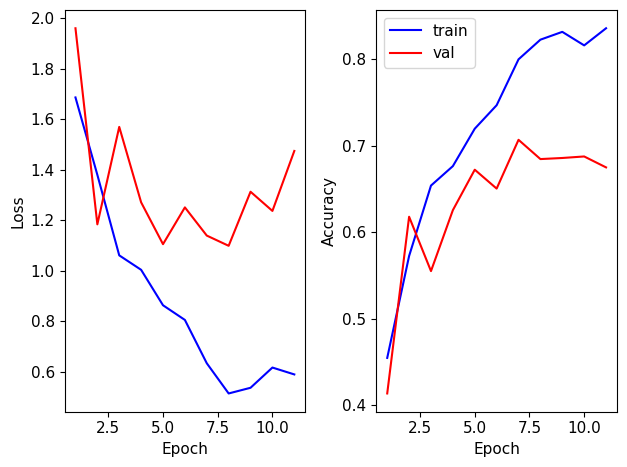

[Epoch 12/50 train] Loss: 0.84, Accuracy: 78.47%:  28%|██▊       | 18/64 [00:08<00:22,  2.01it/s]


KeyboardInterrupt: 

In [90]:
%matplotlib inline

from IPython.display import clear_output
from tqdm import tqdm                           # this gives us a handy progress bar
from torch.utils.data import DataLoader
from torch.optim import SGD
import matplotlib.pyplot as plt


# hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


# this is just for plotting
fig = plt.figure(figsize=(12, 6))
def plot_vals(loss_train, loss_val, accuracy_train, accuracy_val):
    clear_output(wait=True)
    epochs = np.arange(1, len(loss_train)+1, dtype=int)
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(epochs, loss_train, 'b-')
    plt.plot(epochs, loss_val, 'r-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy_train, 'b-', label='train')
    plt.plot(epochs, accuracy_val, 'r-', label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


# create data augmentation transforms for training and prediction
transforms_train = T.Compose([T.Resize([224, 224]),
                              T.RandomHorizontalFlip(),
                              T.RandomGrayscale(),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
                              ])

transforms_test = T.Compose([T.Resize([224, 224]),
                             T.ToTensor(),
                             T.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                            ])


# create dataset and DataLoader instances for the training and validation splits
dataset_train = CTImageDataset(DATA_FOLDER,
                               'train',
                               transforms_train)

dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0)

dataset_val = CTImageDataset(DATA_FOLDER,
                             'val',
                             transforms_test)

dataloader_val = DataLoader(dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=0)

# create model and adapt for our purposes
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(dataset_train.label_lut))

# create optimiser for model we defined above
optimiser = SGD(model.parameters(),
                lr=LEARNING_RATE,
                weight_decay=WEIGHT_DECAY,
                momentum=MOMENTUM)

# loss function/criterion: multi-class cross-entropy loss
criterion = nn.CrossEntropyLoss()

# put model on device
model.to(DEVICE)

# keep track of loss and accuracy values over epochs
loss_train, accuracy_train = [], []
loss_val, accuracy_val = [], []

# iterate over epochs
for epoch in range(1, NUM_EPOCHS+1):
    # train
    model.train()

    loss_train_epoch, accuracy_train_epoch = 0.0, 0.0

    with tqdm(dataloader_train) as progress_bar:
        for idx, (data, target) in enumerate(dataloader_train):
            # put data and target (label) tensors on device
            data, target = data.to(DEVICE), target.to(DEVICE)

            pred = model(data)
            loss = criterion(pred, target)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            loss_train_epoch += loss.item()
            accuracy_train_epoch += torch.mean((pred.argmax(1) == target).float()).item()

            progress_bar.set_description(
                f'[Epoch {epoch}/{NUM_EPOCHS} train] Loss: {loss_train_epoch/(idx+1):.2f}, ' + \
                    f'Accuracy: {accuracy_train_epoch/(idx+1):.2%}')
            progress_bar.update(1)
        
        loss_train.append(loss_train_epoch / len(dataloader_train))
        accuracy_train.append(accuracy_train_epoch / len(dataloader_train))


    # validate
    model.eval()

    loss_val_epoch, accuracy_val_epoch = 0.0, 0.0

    with torch.no_grad():
        with tqdm(dataloader_val) as progress_bar:
            for idx, (data, target) in enumerate(dataloader_val):
                # put data and target (label) tensors on device
                data, target = data.to(DEVICE), target.to(DEVICE)

                pred = model(data)
                loss = criterion(pred, target)

                loss_val_epoch += loss.item()
                accuracy_val_epoch += torch.mean((pred.argmax(1) == target).float()).item()

                progress_bar.set_description(
                    f'[Epoch {epoch}/{NUM_EPOCHS}   val] Loss: {loss_val_epoch/(idx+1):.2f}, ' + \
                        f'Accuracy: {accuracy_val_epoch/(idx+1):.2%}')
                progress_bar.update(1)
            
            loss_val.append(loss_val_epoch / len(dataloader_val))
            accuracy_val.append(accuracy_val_epoch / len(dataloader_val))
    
    # plot loss and accuracy curves after each epoch
    plot_vals(loss_train, loss_val, accuracy_train, accuracy_val)

Take a good moment to go through the above code block. Much of it should be familiar to you – you
have seen all the relevant parts in the exercise last week.

Then, go ahead and execute the cell. While it is running, read the next section.

### 3.6 GPUs, TPUs and Parallel Accelerators

As you run the model training loop above, you notice one primary problem: it is _extremely slow_.
Now we really can feel the "big" images and eleven million parameters of our model; the computer in
the Google Colab cloud has a lot to calculate.

We now finally get to see what parallel computing hardware can do for us! One of the most common
(and traditional) devices to do this is the **Graphics Processing Unit (GPU)**. As the name
suggests, a GPU actually is a graphics card to draw an image on your screen. However, through a
library called [CUDA](https://developer.nvidia.com/cuda-toolkit), we can use it to perform
non-graphical computations, too.


The first step is to make a GPU available:

🖌️ In the menu bar at the top of the browser window, click "Runtime" > "Change Runtime Type".
Choose an available GPU option (_e.g._, "T4 GPU").

We can now use a GPU to perform calculations. However, PyTorch doesn't automatically do this; by
default, it still only uses the Central Processing Unit (CPU).

Instead, we need to tell PyTorch to perform computations on the GPU. This includes moving tensors
over to the correct device. For example:

In [ ]:
import torch

# create a new random tensor
my_tensor = torch.randn((1, 3, 224, 224))

# here's the device the tensor is currently on
print(f'Tensor device: {my_tensor.device}')

# we can move the tensor to a CUDA-capable GPU. Let's first test whether CUDA is available:
print(f'CUDA is available: {torch.cuda.is_available()}')
print(f'Number of CUDA devices (GPUs): {torch.cuda.device_count()}')

# if we have a CUDA-capable GPU available, we can move the tensor over:
DEVICE = 'cuda'
my_tensor = my_tensor.to(DEVICE)
print(f'Tensor device: {my_tensor.device}')

To run computations on the GPU, we need to make sure all involved tensors, including the model's
parameters, are on the exact same device. Therefore:

In [23]:
# also move model over to the right device
model = model.to(DEVICE)

# predict
with torch.no_grad():
    pred = model(my_tensor)

Finally, once we are done, we have to move tensors back to the system memory ("CPU"). This is
important if we want to do anything with them outside PyTorch (_e.g._, visualisation):

In [ ]:
# move prediction over to main memory (CPU)
pred = pred.cpu()

Let's use this above!

🖌️ Go back up to the main model training routine and implement this idea: modify the code so that
the model, data and label tensors (`X`, `y`) are on the "cuda" device. Make sure to modify both
training and validation blocks. Then, execute the code cell and observe the change in speed.

💡 Tips:
- Add an extra hyperparameter `DEVICE = "cuda"` at the top and use it (_e.g._, `model =
  model.to(DEVICE)`).
- If you call `.item()` on a (single-valued) Tensor, you don't need to call `.cpu()` first.
- CUDA GPUs aren't the only type of accelerator. For example, if you have a recent Macintosh with
  Apple Silicon CPU (Apple M1 or later), try the
  [MPS](https://pytorch.org/docs/stable/notes/mps.html) backend – you may be surprised what it can
  do!

**Technical background on parallel accelerators**

_Note: this section provides a high-level background on what parallel accelerators do
under the bonnet. You can skip it if you are not interested in how this all works technically._

The central processing unit (CPU) in a computer is very powerful and versatile: it can be programmed
to execute very long chains of operations that ultimately run the code you implement. However, this
versatility comes at a cost: CPUs are not designed to run many operations in parallel. Sure, modern
CPUs have multiple cores (resp. threads) that can do chunks of work in parallel, but often just a
low number of those.

In deep learning, however, we often need to compute _the exact same operation_ for many values: for
example, if you apply a fully-connected layer to a tensor of 1000 elements, you need to perform the
same operation (multiplication) 1000 times. In simplified terms, a CPU will have to do those
sequentially, one-by-one, in a for-loop. That takes 1000 compute cycles, which is expensive.

This is where parallel accelerators like GPUs come in. These are the opposite of CPUs in some form:
they only offer very shallow processing pipelines, that is, you cannot program them to compute lots
of operations one after the other in a single run. However, you can tell them to _e.g._ do a
multiplication – but across many thousand cores at once and in parallel. Here is an image showing
the architecture of a CUDA GPU:

<img src="https://developer-blogs.nvidia.com/wp-content/uploads/2018/09/image2.jpg" width="800" />

It might be difficult to see, but each of these green rectangles contains many operation cores. You
can program them to receive individual values each, but all perform the same operation in parallel.
For example, the NVIDIA RTX 5090 has over 24,000 CUDA cores
([source](https://www.tomshardware.com/pc-components/gpus/rtx-5090-prototype-allegedly-has-24-576-cuda-cores-and-800w-tdp-two-16-pin-connectors-present)),
which means that you could perform as many multiplications as those in a single compute cycle! Now
you can see why GPUs & Co. are so useful for deep learning: pretty much every operation can be
computed in isolation for each value in a tensor, be it linear transformation, nonlinear activation,
convolution, pooling, _etc._

Finally, parallel accelerators like GPUs usually have their own memory, because system RAM isn't
fast enough. Hence, we need to copy over the tensors to the right device first, hence the
`.to(DEVICE)` calls.

### 3.8 Data Augmentation

Above, we talked about transforms. Torchvision has a lot more of those implemented
([documentation](https://pytorch.org/vision/0.9/transforms.html)). You will notice that some of them
do rather interesting things, often randomly. Why?

If you think about it, we could _e.g._ horizontally flip _any_ of our camera trap images and they
still would show us the exact same object category: a car is a car, whether it's turned left-right
or right-left. Likewise, some of our images are in greyscale because of night vision; we could just
as well turn colour images greyscale and they would still show the same thing.

We can use this information to **augment** our training images. By randomly applying such data
augmentation transforms to an image, we can artificially expand the complexity of the data that our
model sees. As a result, the model learns to be more invariant to _e.g._ left-right orientations,
colour jitterings, random greyscale, _etc._ – it becomes better and more robust!

🖌️ Implement data augmentation above by altering the `transform` the datasets receive as argument.
Then, run the code cell to train the model.

**Notes:**
- Only apply random augmentations to the training images, not the validation or test (can you figure
  out why?).
- Think carefully which augmentations you want to use, and with which hyperparameters. For example,
  a random _vertical_ image flip makes no sense for a camera trap image (having the sky at the
  bottom is unrealistic), but could be useful for _e.g._ remote sensing imagery.

Save the model at current epoch if you want:

In [56]:
model_data = {
    'model': model.state_dict(),        # parameters
    'loss_train': loss_train,           # we'll also save training stats to identify the model later
    'loss_val': loss_val,
    'accuracy_train': accuracy_train,
    'accuracy_val': accuracy_val
}

with open(f'model_epoch_{epoch}.pt', 'wb') as f_out:
    torch.save(model_data, f_out)

Let's use it to predict our test set:

In [ ]:
dataset_test = CTImageDataset(DATA_FOLDER,
                              'test',
                              transforms_test)

dataloader_test = DataLoader(dataset_test,
                             batch_size=BATCH_SIZE,
                             shuffle=False)


# put model in evaluation mode
model.eval()

loss_test_epoch, accuracy_test_epoch = 0.0, 0.0

# let's store predictions and ground truth for accuracy evaluation later
predictions_test, groundtruth_test = [], []

with torch.no_grad():
    with tqdm(dataloader_test) as progress_bar:
        for idx, (data, target) in enumerate(dataloader_test):
            data, target = data.to(DEVICE), target.to(DEVICE)

            pred = model(data)
            loss = criterion(pred, target)

            loss_test_epoch += loss.item()
            accuracy_test_epoch += torch.mean((pred.argmax(1) == target).float()).item()

            predictions_test.append(pred.cpu())
            groundtruth_test.append(target.cpu())

            progress_bar.set_description(
                f'[Epoch {epoch+1}/{NUM_EPOCHS}  test] Loss: {loss_test_epoch/(idx+1):.2f}, ' + \
                    f'Accuracy: {accuracy_test_epoch/(idx+1):.2%}')
            progress_bar.update(1)


predictions_test, groundtruth_test = torch.cat(predictions_test, 0), torch.cat(groundtruth_test, 0)

Let's see how well your model did:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_true=groundtruth_test.numpy(),
                                        y_pred=predictions_test.argmax(1).numpy(),
                                        ax=plt.gca())
_ = plt.yticks(range(len(classes)), classes)
_ = plt.xticks(range(len(classes)), classes, rotation=90)

### 3.9 Bonus: Deep Features

_Please check out this part last (after Section 3) and only if you have time._

If we go back to the architecture diagram of our CNN, we can see that it uses convolution + pooling
layers to condense all spatial information down into a one-dimensional feature vector, and then
employs a final, fully-connected layer to make class predictions. We have also seen that those
intermediate output features change their significance: the first ones are more geometric (blobs,
gradients), but as we go through the layers, they become more _semantic_, useful for classifying
images.

Thus, this second-to-last, one-dimensional feature vector just before the final layer is often very
interesting, because it summarises the image contents non-spatially. We can use this for many things
in deep learning, one of which is to see how well the model manages to separate images by label
class.

Let us first extract those feature vectors from the validation images.

In [92]:
predictions, labels, feature_vectors = [], [], []

# this allows us to capture the final, linear layer's input (i.e., our feature vector)
def store_feature(module, input, output):
    global feature_vectors
    feature_vectors.append(input[0].cpu())

hook = None
if len(model.fc._forward_hooks) == 0:
    hook = model.fc.register_forward_hook(store_feature)

# iterate over validation set
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval()
with torch.no_grad():
    for X, y in tqdm(dataloader_val):
        labels.append(y)
        pred = model(X.to(device))
        y_hat = pred.argmax(dim=1)
        predictions.append(y_hat.cpu())

# combine our outputs
predictions = torch.cat(predictions, 0)
labels = torch.cat(labels, 0)
feature_vectors = torch.cat(feature_vectors, 0)

# clean up
if hook is not None:
    hook.remove()

print(f'Size of tensor with combined feature vectors: {feature_vectors.size()}')

100%|██████████| 11/11 [00:13<00:00,  1.23s/it]

Size of tensor with combined feature vectors: torch.Size([674, 512])


ResNet-18 produces a 512-dimensional feature vector before the last layer, and we have one for each
validation image (hence this specific size). So what can we do with this now?

Remember dimensionality reduction methods from Session 2, such as PCA, t-SNE and UMAP? Let's apply
one of those to compress the 512 dimensions down to two, and plot the points coloured by their
ground truth label accordingly!

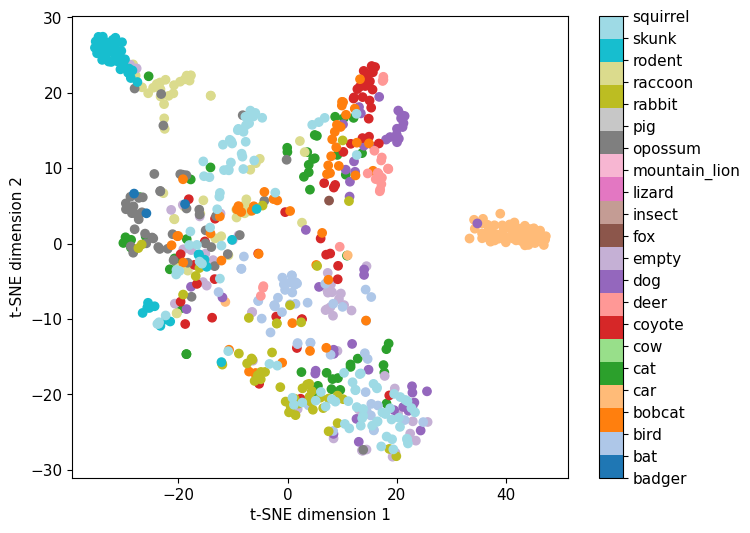

In [93]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(feature_vectors.numpy())

with open(os.path.join(DATA_FOLDER, 'classes.txt'), 'r', encoding='utf-8') as f_cls:
    classes = [line.strip() for line in f_cls.readlines() if len(line) > 0]

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab20')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
cbar = plt.colorbar()
cbar.ax.set_yticks(range(len(classes)), classes)
plt.show()

---

## 4. Object Detection

Above, we used a CNN to classify camera trap images based on the animal species they showed. This
can be useful, but also has its limitations:
* Some of the animals can be really hard to spot because they may occupy only a very small portion
  of the image. An image-level classifier might not be very helpful for those cases.
* Worse, it has no means of identifying two or more animals (from different species) occurring in
  the same image.


This is where object detection comes in. Detection consists in predicting _bounding boxes_ for every
_instance_ of an object category in an image. An object detection model thus has to return the
following information for every image:
* A list (tensor, _etc._) of $N\times4$ values, denoting bounding box coordinates (_e.g._, `[x, y,
  width, height]`) for $N$ object instances.
* A list (tensor, _etc._) of $N\times C$ logits, denoting model outputs for all $C$ categories
  (classes) for each of the $N$ object instances.


### 4.1 Manual Image Annotation

The idea above provides us with a lot more information about the image contents, but it comes at a
cost: it is much more expensive to manually annotate, because one has to draw bounding boxes _and_
assign the correct species for every individual in an image.

🖌️ Let us see this for real. Execute the code block below. You will be presented with an image.
Your task is to draw bounding boxes around all animals you see in the image. To do so, select the
right species from the list and click and drag to draw a box. Once you are finished, click "Next"
(or "Skip" if there's no animal in the image) and continue with the next image. Note that the time
required for you to label each image will be recorded.

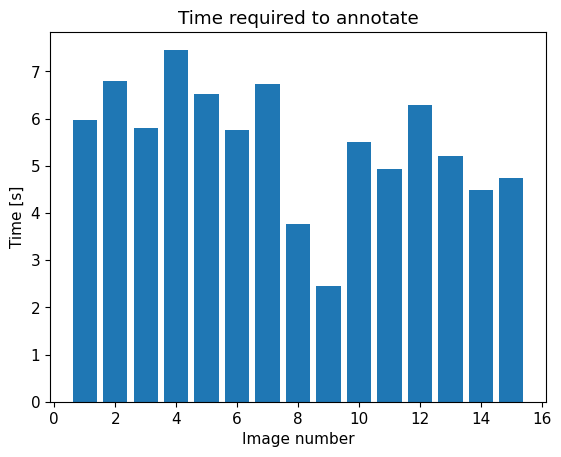

In [94]:
import time
from jupyter_bbox_widget import BBoxWidget
import ipywidgets as widgets


# load label class order for ground truth
with open(os.path.join(DATA_FOLDER, 'classes.txt'), 'r', encoding='utf-8') as f_classes:
    box_classes = [line.strip() for line in f_classes.readlines() if len(line.strip()) > 0]


#TODO
images_subset = np.random.choice(images, 15, replace=False)     #TODO

# outputs
times, boxes_user = [], []


w_progress = widgets.IntProgress(value=0, max=len(images_subset)-1, description='Progress')

w_boxes = BBoxWidget(
    image=images_subset[0],
    classes=box_classes,
)
w_container = widgets.VBox([
    w_progress,
    w_boxes,
])

# start recording time
tic = time.time()

def next():
    global tic
    if w_progress.value >= len(images_subset)-1:
        # end reached
        w_container.close()
        finish()
        return

    # go to next image and reset properties
    w_progress.value += 1
    image_file = images_subset[w_progress.value]
    w_boxes.image = image_file
    w_boxes.bboxes = []

    # reset timer
    tic = time.time()


@w_boxes.on_skip
def skip():
    global tic
    # append time and empty lists for labels and boxes
    times.append(time.time() - tic)
    boxes_user.append([])

    next()

@w_boxes.on_submit
def submit():
    global tic
    # append time and lists for labels and boxes
    times.append(time.time() - tic)
    boxes_user.append(w_boxes.bboxes)

    next()


def finish():
    # show times required (TODO)
    plt.bar(np.arange(1, len(times)+1), times)
    plt.xlabel('Image number')
    plt.ylabel('Time [s]')
    plt.title('Time required to annotate')
    plt.show()

w_container

Once you have finished, you should see a bar chart that shows you how much time you needed for each
image to annotate. As you can see, this is a rather time-consuming endeavour.

Also, you may have found it rather difficult to label the images: some of the animals are really
tiny, some are blurry, and some may be hard to identify. Imagine distinguishing between two related
and visually similar species – that's hard and requires lots of taxonomic knowledge!

Let's compare your annotations to those made by experts:

In [124]:
%matplotlib inline


def draw_side_by_side(images,
                      classes_a,
                      classes_b,
                      boxes_a,
                      boxes_b,
                      title_a,
                      title_b):

    w_progress = widgets.IntProgress(value=0, max=len(images)-1, description='Image')
    w_boxes_a = BBoxWidget(
        classes=classes_a,
        view_only=True,
        hide_buttons=True
    )
    w_boxes_b = BBoxWidget(
        classes=classes_b,
        view_only=True,
        hide_buttons=True
    )

    def draw_image():
        img_path = images[w_progress.value]
        w_boxes_a.image = img_path
        w_boxes_b.image = img_path

        w_boxes_a.bboxes = boxes_a[w_progress.value]
        w_boxes_b.bboxes = boxes_b[w_progress.value]

    def prev(event=None):
        w_progress.value -= 1
        draw_image()

    def next(event=None):
        w_progress.value += 1
        draw_image()

    btn_prev = widgets.Button(description='<')
    btn_prev.on_click(prev)

    btn_next = widgets.Button(description='>')
    btn_next.on_click(next)

    draw_image()

    output = widgets.VBox([
        widgets.HBox([btn_prev, btn_next]),
        w_progress,
        widgets.HBox([widgets.HTML(f'{title_a} (left),'), widgets.HTML(f'{title_b} (right)')]),
        widgets.HBox([w_boxes_a, w_boxes_b])
    ])
    display(output)


# load ground truth boxes for the sample images
gt_boxes = []
for img_path in images_subset:
    anno_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
    if not os.path.exists(anno_path):
        gt_boxes.append([])
        continue
    with open(anno_path, 'r', encoding='utf-8') as f_anno:
        lines = f_anno.readlines()
    tokens = [line.strip().split(' ') for line in lines]
    boxes = torch.tensor([[float(val) for val in box[1:]] for box in tokens])

    # convert to absolute xywh format
    boxes *= torch.tensor([[1024, 768]]).repeat((1, 2))

    labels = [box_classes[int(box[0])] for box in tokens]

    bboxes = [{'x': box[0], 'y': box[1], 'width': box[2], 'height': box[3], 'label': labels[bidx]}
            for bidx, box in enumerate(boxes.numpy().tolist())]
    gt_boxes.append(bboxes)


# display yours along with ground truth boxes side-by-side
draw_side_by_side(images_subset,
                  [],
                  [],
                  gt_boxes,
                  boxes_user,
                  'Ground Truth',
                  'Your Labels')

### 4.2 MegaDetector

One of the most famous animal detection model for camera trap images is
[MegaDetector](https://arxiv.org/abs/1907.06772). It nowadays is implemented in two repositories:
- [MegaDetector](https://github.com/agentmorris/MegaDetector): original implementation
- [PytorchWildlife](https://github.com/microsoft/CameraTraps): new fork

Below, we will use the PytorchWildlife implementation and apply a pre-trained MegaDetector on our
images. First, we need to install the library:

In [ ]:
%pip install PytorchWildlife

If you check the
[documentation](https://github.com/microsoft/CameraTraps?tab=readme-ov-file#mag-model-zoo-and-release-schedules),
you can see that PytorchWildlife comes with lots of pre-trained versions built-in ("Model Zoo").
Let's load one of those:

In [108]:
from PytorchWildlife.models import detection as pw_detection
detection_model = pw_detection.MegaDetectorV6(version='MDV6-yolov10-e')

Ultralytics 8.3.21 🚀 Python-3.9.19 torch-2.5.1 CPU (Apple M4 Pro)
YOLOv10x summary (fused): 503 layers, 31,589,858 parameters, 0 gradients, 169.8 GFLOPs


Here's what that model returns for a single image:

In [102]:
img_path = np.random.choice(images_subset, size=1)[0]

result = detection_model.single_image_detection(img_path,
                                                det_conf_thres=0.2)

print(f'MegaDetector output for image "{img_path}":')
print(result)


0: 480x640 1 animal, 171.6ms
Speed: 1.4ms preprocess, 171.6ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 640)
MegaDetector output for image "/Users/bak45/Documents/Work/4 UCL/Teaching/BIOS0032/2025/BIOS0032_AI4Environment/hidden/04_DL_for_Wildlife_Images/CCT20/data_prepared/train/images/rabbit/5986243d-23d2-11e8-a6a3-ec086b02610b.jpg":
{'img_id': 'None', 'detections': Detections(xyxy=array([[     688.28,      347.76,      768.13,      424.71]], dtype=float32), mask=None, confidence=array([    0.81853], dtype=float32), class_id=array([0]), tracker_id=None, data={}), 'labels': ['animal 0.82']}


💡 All the work on image loading, transforms, normalisation, _etc._, is already built into the
library for you and happening deep within the framework.

Let us see what this looks like for all our images when visualised:

In [125]:
%matplotlib inline

# predict all images
detections = []
for img_path in images_subset:
    result = detection_model.single_image_detection(img_path,
                                                    det_conf_thres=0.2)
    bboxes = result['detections'].xyxy
    detections.append([{
        'x': box[0],
        'y': box[1],
        'width': box[2]-box[0],
        'height': box[3]-box[1],
        'label': result['labels'][bidx]
    } for bidx, box in enumerate(bboxes)])


# visualise
draw_side_by_side(images_subset,
                  [],
                  [],
                  detections,
                  gt_boxes,
                  'MegaDetector predictions',
                  'Ground Truth')


0: 480x640 (no detections), 193.3ms
Speed: 3.6ms preprocess, 193.3ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 animal, 185.0ms
Speed: 1.1ms preprocess, 185.0ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 animals, 185.6ms
Speed: 1.1ms preprocess, 185.6ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 animals, 183.7ms
Speed: 1.1ms preprocess, 183.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 animal, 192.6ms
Speed: 1.0ms preprocess, 192.6ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 animal, 195.9ms
Speed: 1.0ms preprocess, 195.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 animal, 184.1ms
Speed: 1.7ms preprocess, 184.1ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 183.5ms
Speed: 1.1ms preprocess, 183.5ms inference, 0.1ms postproc

Of course, MegaDetector does not know anything about our species and only predicts "animal" (as well
as "human" and "car").

However, this should make you think about how you could create a more powerful model by _e.g._
stringing MegaDetector and our ResNet-18 classifier from above together:
1. Predict animals with MegaDetector
2. Classify each bounding box for its species

This could also improve the (currently rather weak) performance of our classifier, since it would
only receive the part of the image that actually contains the animal!

---

## 5. Summary

We have seen various things today:
* Basic working principles of a Convolutional Neural Network (CNN).
* How to perform computer vision prediction tasks with deep learning, including image classification
  and object detection.
* All of that applied to camera trap species classification and prediction, including challenges
  (tedium of manual annotation, difficulty for a model to do the task) and potential improvements
  (detection followed by classification).

You can imagine that a massive amount of research has gone into improving such models (and still is
ongoing). We cannot cover everything in this module, but you should be able to see where this can
go.

Ultimately, ecological research does not stop at the prediction of species and individuals in an
image, but then uses this information to make _inference_ about biotic processes in space and time,
such as:
* Prediction of habitat suitability (just like we did last week, but using species observations
  identified in camera trap imagery).
* Assessment of predator-prey interactions in space and time (for example, you may find that rabbits
  and wolves have different diurnal times of activity, or else spatial territoriality).
* Other behavioural traits (_e.g._, observing the habits of a mother bear walking by with offspring
  cubs).
* Population counts (we can do this with occupancy models, which we will take a look at in the
  second half of the module).

You can see that lots of ecological research questions can be informed with large-scale sensor and
data inputs, such as from camera traps. Using machine learning to predict species in their imagery
makes sense to increase the scale of prediction – rather than labelling a few images by hand, you
can now use the predictions across millions of images in space and time!

As is often the case in ecology, however, we are most interested in the _rare_ class, such as the
data-deficient species. As you have seen above, deep learning does not cope well with those. Thus,
there is still lots of research to be done!